## Downloading dataset

In [63]:
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d msambare/fer2013 -p ./fer2013
# !unzip ./fer2013/fer2013.zip -d ./fer2013

## Importing libraries

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import torch.nn.functional as F
from PIL import Image, ImageEnhance, ImageFilter
import dlib
import warnings
from torchvision.transforms import functional as TF
import random
import time
from pathlib import Path
import glob
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import random_split
import multiprocessing
warnings.filterwarnings('ignore')

## Visualize the dataset

In [65]:
# get train set classes
train_set_path = "./fer2013/train"
emotion_folders_train = [f for f in os.listdir(train_set_path) if os.path.isdir(os.path.join(train_set_path, f))]
emotion_folders_train

['sad', 'fear', 'angry', 'neutral', 'surprise', 'happy', 'disgust']

In [66]:
# get test set classes
test_set_path = "./fer2013/test"
emotion_folders_test = [f for f in os.listdir(test_set_path) if os.path.isdir(os.path.join(test_set_path, f))]
emotion_folders_test

['sad', 'fear', 'angry', 'neutral', 'surprise', 'happy', 'disgust']

In [67]:
# That is there are 7 classes
# Obtain a sample of images (2 from each class) to visualize

num_samples = 14
sample_images = []
sample_labels = []

for emotion in emotion_folders_train:
  emotion_path = os.path.join(train_set_path, emotion)
  if not os.path.exists(emotion_path):
      continue

  image_files = glob.glob(os.path.join(emotion_path, "*.jpg")) + \
                glob.glob(os.path.join(emotion_path, "*.png")) + \
                glob.glob(os.path.join(emotion_path, "*.jpeg"))

  if len(image_files) == 0:
      continue

  # Sample random images from this emotion
  num_to_sample = min(num_samples // len(emotion_folders_train), len(image_files))
  sampled_files = random.sample(image_files, num_to_sample)

  for img_path in sampled_files:
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
      if img is not None:
          sample_images.append(img)
          sample_labels.append(emotion)
print(len(sample_images))
print(len(sample_labels))

14
14


In [68]:
## sample image shape
sample_images[0].shape

(48, 48)

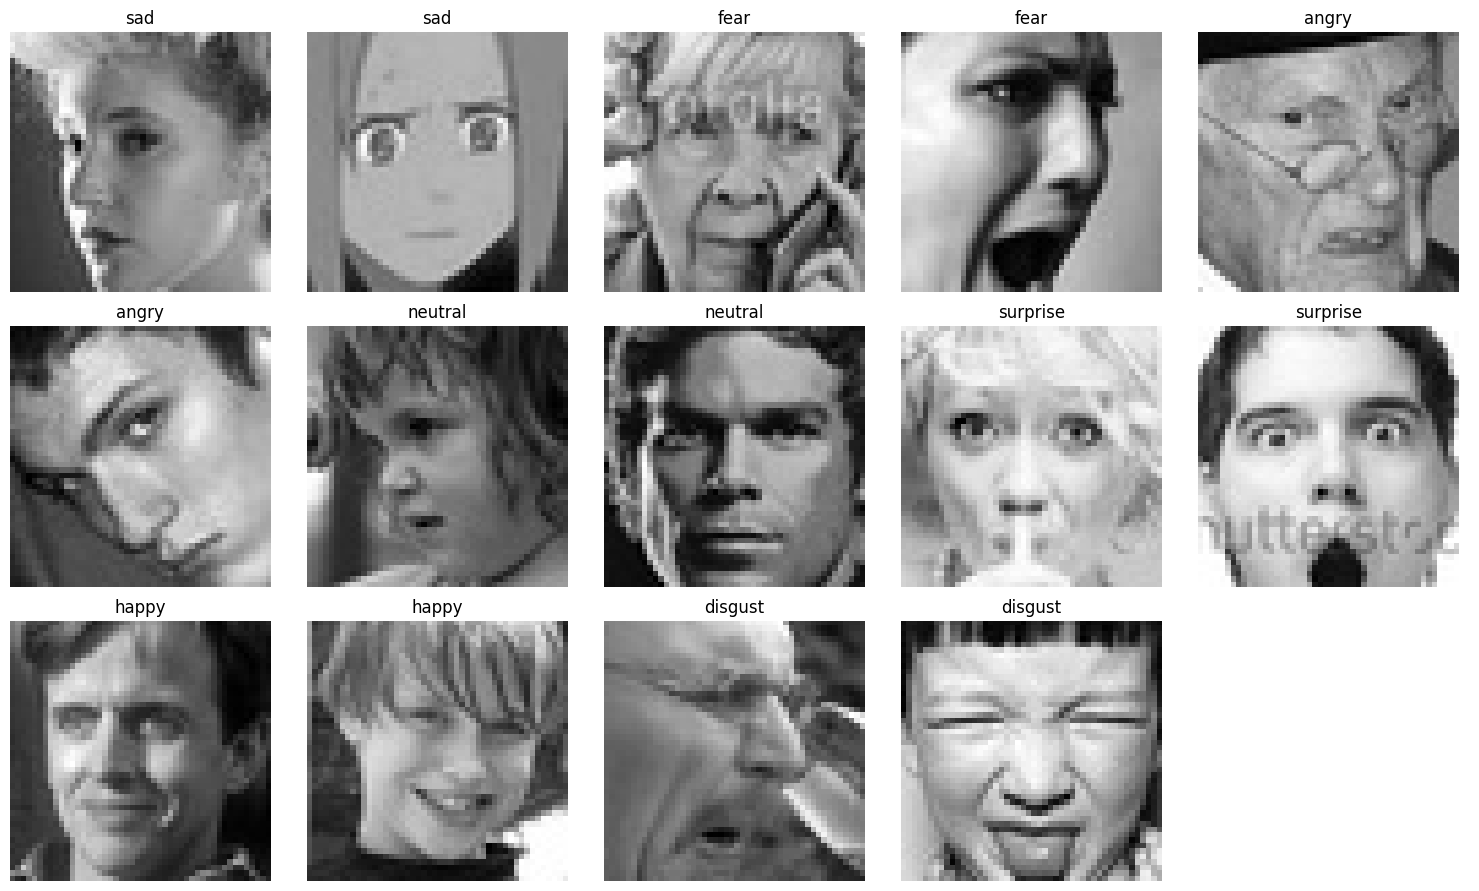

In [69]:
import math

num_samples = len(sample_images)
cols = 5
rows = math.ceil(num_samples / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))

for i, ax in enumerate(axes.flat):
    if i < num_samples:
        ax.imshow(sample_images[i], cmap='gray')
        ax.set_title(sample_labels[i])
    ax.axis('off')  # Hide unused axes

plt.tight_layout()
plt.show()


In [70]:
# Transform the images
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [71]:
# Obtaining training and test sets
def load_dataset(root_dir, transform):
    emotions = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])
    emotion_to_idx = {emotion: idx for idx, emotion in enumerate(emotions)}

    images, labels = [], []
    for emotion, idx in emotion_to_idx.items():
        emotion_dir = os.path.join(root_dir, emotion)
        for fname in os.listdir(emotion_dir):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(emotion_dir, fname)

                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (48, 48))
                img = Image.fromarray(img)
                img = transform(img)

                images.append(img)
                labels.append(idx)

    # make an object with same attributes as your class
    dataset = lambda: None  # empty object
    dataset.images = images
    dataset.labels = labels
    dataset.emotion_to_idx = emotion_to_idx
    return dataset

train_dataset = load_dataset(train_set_path, train_transform)
test_dataset  = load_dataset(test_set_path, test_transform)

print("Train samples:", len(train_dataset.labels))
print("Test samples :", len(test_dataset.labels))

Train samples: 28709
Test samples : 7178


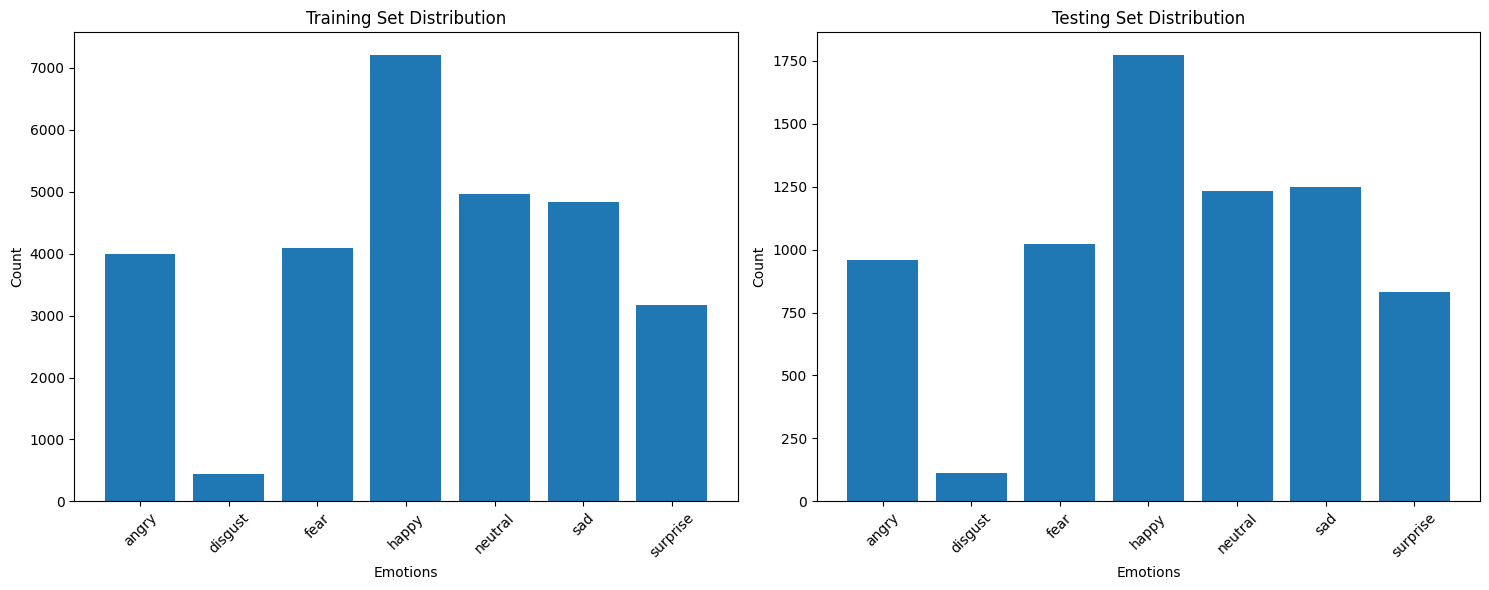

In [72]:
# Visualize the distribution of emotions in the dataset
# Plot class distribution
train_labels = [train_dataset.labels[i] for i in range(len(train_dataset.labels))]
test_labels = [test_dataset.labels[i] for i in range(len(test_dataset.labels))]

emotions = list(train_dataset.emotion_to_idx.keys())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Training distribution
train_counts = pd.Series(train_labels).value_counts().sort_index()
ax1.bar(range(len(emotions)), train_counts.values)
ax1.set_title('Training Set Distribution')
ax1.set_xlabel('Emotions')
ax1.set_ylabel('Count')
ax1.set_xticks(range(len(emotions)))
ax1.set_xticklabels(emotions, rotation=45)

# Testing distribution
test_counts = pd.Series(test_labels).value_counts().sort_index()
ax2.bar(range(len(emotions)), test_counts.values)
ax2.set_title('Testing Set Distribution')
ax2.set_xlabel('Emotions')
ax2.set_ylabel('Count')
ax2.set_xticks(range(len(emotions)))
ax2.set_xticklabels(emotions, rotation=45)

plt.tight_layout()
plt.show()


## Testing with different image processing techniques

### Defining the image processing techniques

In [73]:
class ImageProcessingTechniques:

    def __init__(self):
        # Pre-compute CLAHE objects for reuse
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        self.clahe_light = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))
        self.clahe_strong = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(6, 6))

        # Pre-compute morphological kernels
        self.kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        self.kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

        # Pre-compute gamma correction tables for common values
        self.gamma_tables = {}
        for gamma in [0.7, 0.8, 0.9, 1.1, 1.2, 1.3]:
            inv_gamma = 1.0 / gamma
            self.gamma_tables[gamma] = np.array([((i / 255.0) ** inv_gamma) * 255
                                               for i in np.arange(0, 256)]).astype("uint8")

    def original(self, image):
        """Return original image"""
        return image

    def combined_enhancement_fast(self, image):
        """Optimized combined enhancement with comprehensive processing"""
        # Step 1: Noise reduction with bilateral filter (preserves edges better than Gaussian)
        denoised = cv2.bilateralFilter(image, 5, 50, 50)

        # Step 2: Adaptive histogram equalization for local contrast
        enhanced = self.clahe.apply(denoised)

        # Step 3: Gamma correction for brightness adjustment
        # Dynamic gamma based on image brightness
        mean_brightness = np.mean(enhanced)
        if mean_brightness < 100:  # Dark image
            gamma = 1.2
        elif mean_brightness > 150:  # Bright image
            gamma = 0.8
        else:  # Normal image
            gamma = 1.0

        if gamma != 1.0:
            inv_gamma = 1.0 / gamma
            table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
            gamma_corrected = cv2.LUT(enhanced, table)
        else:
            gamma_corrected = enhanced

        # Step 4: Edge-preserving sharpening with unsharp mask
        gaussian = cv2.GaussianBlur(gamma_corrected, (3, 3), 1.0)
        sharpened = cv2.addWeighted(gamma_corrected, 1.6, gaussian, -0.6, 0)

        # Step 5: Contrast enhancement using CLAHE again (lighter touch)
        clahe_light = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(4, 4))
        final_enhanced = clahe_light.apply(sharpened)

        # Step 6: Subtle morphological enhancement to clean up noise
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        final_result = cv2.morphologyEx(final_enhanced, cv2.MORPH_CLOSE, kernel)

        # Ensure values are in valid range
        final_result = np.clip(final_result, 0, 255).astype(np.uint8)

        return final_result

    def enhancement_aggressive(self, image):
        """More aggressive enhancement for challenging images"""
        # Step 1: Strong noise reduction
        denoised = cv2.fastNlMeansDenoising(image, None, h=10, templateWindowSize=7, searchWindowSize=21)

        # Step 2: Strong CLAHE
        enhanced = self.clahe_strong.apply(denoised)

        # Step 3: Histogram stretching for better contrast
        p2, p98 = np.percentile(enhanced, (2, 98))
        stretched = np.clip((enhanced - p2) * 255.0 / (p98 - p2), 0, 255).astype(np.uint8)

        # Step 4: Strong gamma correction
        gamma_corrected = cv2.LUT(stretched, self.gamma_tables.get(1.3, self.gamma_tables[1.2]))

        # Step 5: Edge enhancement with Laplacian
        laplacian = cv2.Laplacian(gamma_corrected, cv2.CV_64F, ksize=3)
        laplacian = np.uint8(np.absolute(laplacian))
        edge_enhanced = cv2.add(gamma_corrected, (laplacian * 0.3).astype(np.uint8))

        # Step 6: Final smoothing
        final_result = cv2.bilateralFilter(edge_enhanced, 3, 20, 20)

        return np.clip(final_result, 0, 255).astype(np.uint8)

    def enhancement_subtle(self, image):
        """Subtle enhancement for already good quality images"""
        # Step 1: Light noise reduction
        denoised = cv2.GaussianBlur(image, (3, 3), 0.5)

        # Step 2: Mild CLAHE
        enhanced = self.clahe_light.apply(denoised)

        # Step 3: Subtle sharpening
        gaussian = cv2.GaussianBlur(enhanced, (5, 5), 1.5)
        sharpened = cv2.addWeighted(enhanced, 1.2, gaussian, -0.2, 0)

        # Step 4: Minor contrast adjustment
        alpha = 1.1  # Contrast control
        beta = 5     # Brightness control
        adjusted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

        return np.clip(adjusted, 0, 255).astype(np.uint8)

    def enhancement_adaptive(self, image):
        """Adaptive enhancement based on image characteristics"""
        # Analyze image characteristics
        mean_val = np.mean(image)
        std_val = np.std(image)
        contrast_ratio = std_val / mean_val if mean_val > 0 else 0

        # Choose enhancement strategy based on image characteristics
        if mean_val < 80:  # Dark image
            return self.enhancement_for_dark_images(image)
        elif mean_val > 170:  # Bright image
            return self.enhancement_for_bright_images(image)
        elif contrast_ratio < 0.3:  # Low contrast
            return self.enhancement_for_low_contrast(image)
        else:  # Normal image
            return self.combined_enhancement_fast(image)

    def enhancement_for_dark_images(self, image):
        """Specialized enhancement for dark images"""
        # Brighten using gamma correction
        gamma_corrected = cv2.LUT(image, self.gamma_tables.get(1.3, self.gamma_tables[1.2]))

        # Strong CLAHE for local contrast
        enhanced = self.clahe_strong.apply(gamma_corrected)

        # Reduce noise that becomes visible after brightening
        denoised = cv2.bilateralFilter(enhanced, 5, 60, 60)

        return denoised

    def enhancement_for_bright_images(self, image):
        """Specialized enhancement for bright/overexposed images"""
        # Darken using gamma correction
        gamma_corrected = cv2.LUT(image, self.gamma_tables.get(0.8, self.gamma_tables[0.7]))

        # Mild CLAHE to avoid over-enhancement
        enhanced = self.clahe_light.apply(gamma_corrected)

        # Subtle sharpening
        gaussian = cv2.GaussianBlur(enhanced, (3, 3), 1.0)
        sharpened = cv2.addWeighted(enhanced, 1.3, gaussian, -0.3, 0)

        return sharpened

    def enhancement_for_low_contrast(self, image):
        """Specialized enhancement for low contrast images"""
        # Histogram stretching
        p1, p99 = np.percentile(image, (1, 99))
        stretched = np.clip((image - p1) * 255.0 / (p99 - p1), 0, 255).astype(np.uint8)

        # Strong CLAHE
        enhanced = self.clahe_strong.apply(stretched)

        # Edge enhancement
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        sharpened = cv2.filter2D(enhanced, -1, kernel)

        # Blend original and sharpened
        final_result = cv2.addWeighted(enhanced, 0.7, sharpened, 0.3, 0)

        return np.clip(final_result, 0, 255).astype(np.uint8)

    # Additional classic enhancement methods for comparison
    def histogram_equalization(self, image):
        """Apply histogram equalization"""
        return cv2.equalizeHist(image)

    def adaptive_histogram_equalization(self, image):
        """Apply Contrast Limited Adaptive Histogram Equalization (CLAHE)"""
        return self.clahe.apply(image)

    def gaussian_blur(self, image, kernel_size=3):
        """Apply Gaussian blur for noise reduction"""
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    def unsharp_masking(self, image, kernel_size=5, sigma=1.0, amount=1.0):
        """Apply unsharp masking for edge enhancement"""
        blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
        sharpened = cv2.addWeighted(image, float(amount + 1), blurred, -float(amount), 0)
        return np.clip(sharpened, 0, 255).astype(np.uint8)

    def bilateral_filter(self, image, d=9, sigmaColor=75, sigmaSpace=75):
        """Apply bilateral filter for noise reduction while preserving edges"""
        return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

### Comparison

In [74]:
# Function to load sample images from different emotion categories
def load_sample_images(dataset_path, num_samples=8):

    sample_images = []
    sample_labels = []

    # Look for emotion folders
    if os.path.exists(dataset_path):
        emotion_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
    else:
        print(f"Dataset path {dataset_path} not found!")
        return [], []

    samples_per_emotion = max(1, num_samples // len(emotion_folders))

    for emotion in emotion_folders[:min(len(emotion_folders), 6)]:  # Limit to 6 emotions for display
        emotion_path = os.path.join(dataset_path, emotion)

        # Get image files
        image_files = []
        for ext in ['*.jpg', '*.png', '*.jpeg', '*.JPG', '*.PNG', '*.JPEG']:
            image_files.extend(glob.glob(os.path.join(emotion_path, ext)))

        if not image_files:
            continue

        # Sample random images
        selected_files = np.random.choice(image_files,
                                        size=min(samples_per_emotion, len(image_files)),
                                        replace=False)

        for img_path in selected_files:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Resize to standard size
                img_resized = cv2.resize(img, (48, 48))
                sample_images.append(img_resized)
                sample_labels.append(emotion)

    return sample_images, sample_labels

### Get image characteristics

In [75]:
# Function to analyze and return image characteristics
def analyze_image_characteristics(image):

    mean_brightness = np.mean(image)
    std_dev = np.std(image)
    contrast_ratio = std_dev / mean_brightness if mean_brightness > 0 else 0

    # Classify image type
    if mean_brightness < 80:
        image_type = "Dark"
    elif mean_brightness > 170:
        image_type = "Bright"
    elif contrast_ratio < 0.3:
        image_type = "Low Contrast"
    else:
        image_type = "Normal"

    return {
        'mean_brightness': mean_brightness,
        'std_dev': std_dev,
        'contrast_ratio': contrast_ratio,
        'image_type': image_type
    }

### Visualize processes images

In [76]:
def visualize_processing_methods(sample_images, sample_labels, max_images=4):
    """
    Visualize different processing methods on sample images
    """
    processor = ImageProcessingTechniques()

    # Define methods to test
    methods = {
        'Original': processor.original,
        'Basic CLAHE': processor.adaptive_histogram_equalization,
        'Histogram Eq.': processor.histogram_equalization,
        'Bilateral Filter': processor.bilateral_filter,
        'Unsharp Mask': processor.unsharp_masking,
        'Subtle Enhancement': processor.enhancement_subtle,
        'Combined Fast': processor.combined_enhancement_fast,
        'Aggressive': processor.enhancement_aggressive,
        'Adaptive': processor.enhancement_adaptive
    }

    num_methods = len(methods)
    num_samples = min(len(sample_images), max_images)

    print(f"Visualizing {num_methods} processing methods on {num_samples} sample images...")

    # Create large figure
    fig, axes = plt.subplots(
      num_samples, num_methods,
      figsize=(20, 2 * num_samples),
      gridspec_kw={'hspace': 0.3, 'wspace': 0.1}
    )

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # Process and display images
    for i in range(num_samples):
        image = sample_images[i]
        label = sample_labels[i]

        # Analyze image characteristics
        characteristics = analyze_image_characteristics(image)

        for j, (method_name, method_func) in enumerate(methods.items()):
            try:
                # Apply processing method
                processed_image = method_func(image.copy())

                # Display image
                axes[i, j].imshow(processed_image, cmap='gray', vmin=0, vmax=255)

                # Set title
                if i == 0:  # Add method name to first row
                    axes[i, j].set_title(f'{method_name}', fontsize=10, fontweight='bold')

                axes[i, j].axis('off')

                # Add emotion label and image info on the leftmost column
                if j == 0:
                    info_text = f'{label}\n{characteristics["image_type"]}\nMean: {characteristics["mean_brightness"]:.0f}\nStd: {characteristics["std_dev"]:.1f}'
                    axes[i, j].set_ylabel(info_text, fontsize=9, rotation=0,
                                         ha='right', va='center')

            except Exception as e:
                print(f"Error processing {method_name} on image {i}: {e}")
                axes[i, j].text(0.5, 0.5, 'Error', ha='center', va='center',
                               transform=axes[i, j].transAxes, fontsize=12, color='red')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig('image_processing_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

In [77]:
# Load 6 samples
sample_images, sample_labels = load_sample_images("fer2013/train", 6)
print(f"Loaded {len(sample_images)} sample images from emotions: {set(sample_labels)}")

Loaded 6 sample images from emotions: {'surprise', 'sad', 'fear', 'neutral', 'happy', 'angry'}


Visualizing 9 processing methods on 6 sample images...


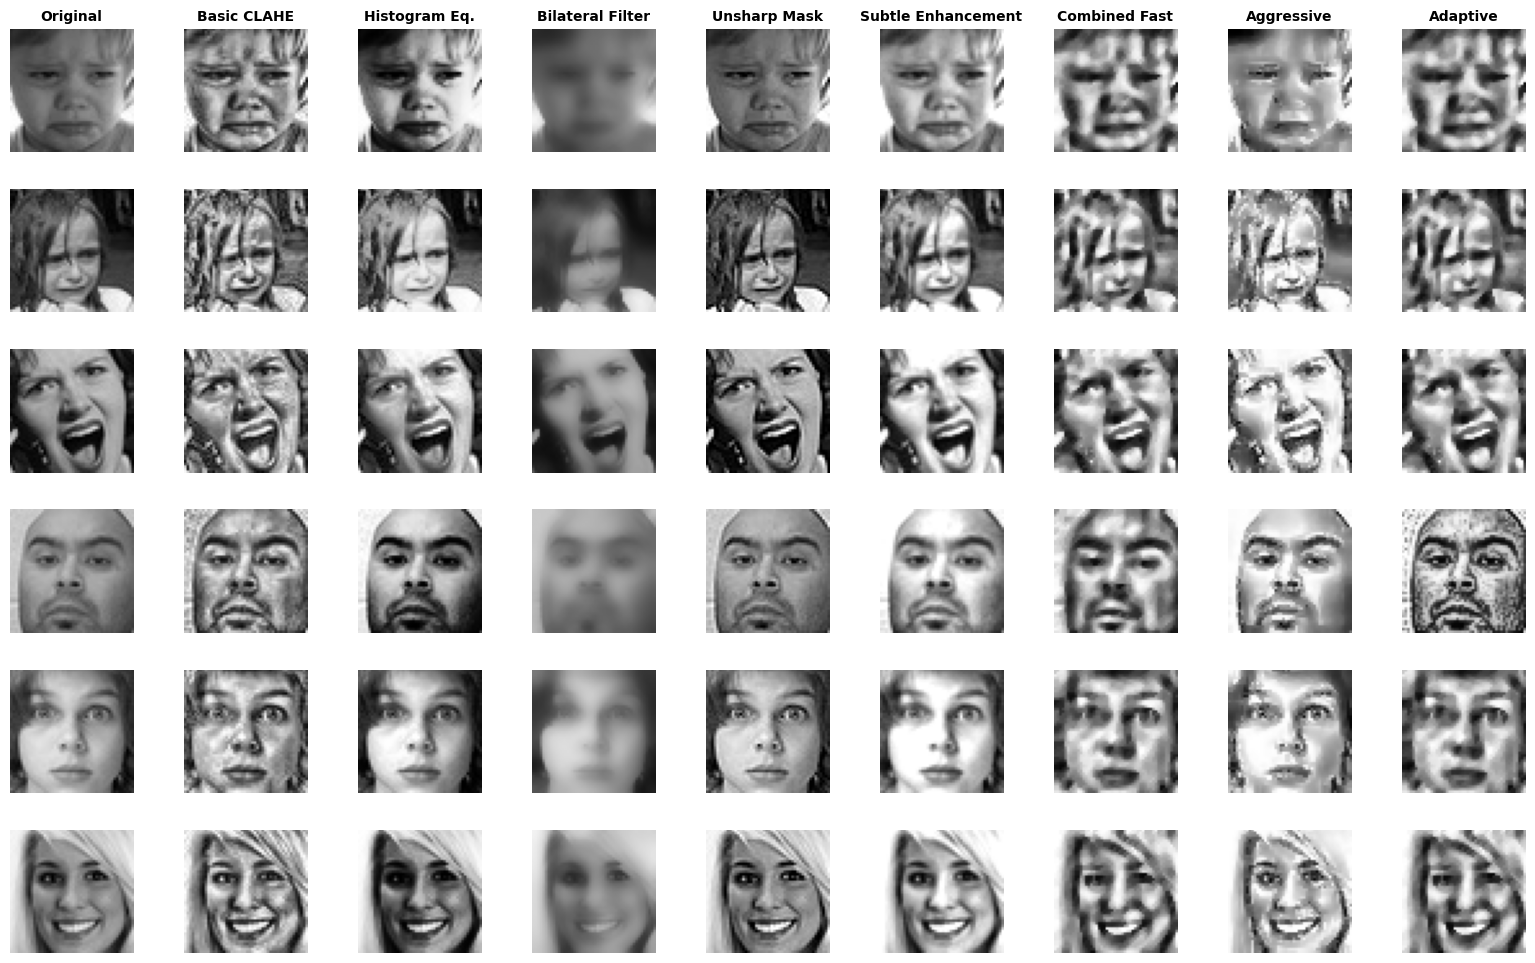

In [78]:
visualize_processing_methods(sample_images, sample_labels, max_images=6)

As we can see from the output, only some of the image processing resulted in a reasonable output. Therefore, we will try to train the model with following techniques:
1. original (no processing)
2. basic CLAHE
3. histogram equalization
4. unsharp mask
5. combined fast
6. subtle enhancement

## Testing the model with different processing techniques applied

### GPU optimization

In [79]:
# GPU Optimization Settings
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = False

# Check CUDA availability and optimize
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name()}")
    device = torch.device('cuda')
    # Enable optimizations
    torch.cuda.empty_cache()
    torch.cuda.set_per_process_memory_fraction(0.95)  # Use 95% of GPU memory
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

CUDA Available: True
CUDA Device: Tesla T4
Using device: cuda


### Optimized image processing class with configurable enhancement technique

In [80]:
class OptimizedImageProcessor:
    """
    Optimized image processing class with configurable enhancement technique
    """

    def __init__(self, technique_name="original"):
        self.technique_name = technique_name
        self.processing_techniques = ImageProcessingTechniques()

        # Get the processing method
        if hasattr(self.processing_techniques, technique_name):
            self.process_method = getattr(self.processing_techniques, technique_name)
        else:
            print(f"Warning: Technique '{technique_name}' not found. Using 'original'.")
            self.process_method = self.processing_techniques.original

    def process_image(self, image):
        """Processing pipeline with selected technique"""
        if image.shape != (48, 48):
            image = cv2.resize(image, (48, 48))

        # Apply the selected technique
        processed = self.process_method(image)
        return processed

### Highly optimized FER2013 Dataset for training

In [81]:
class OptimizedFER2013Dataset(Dataset):

    def __init__(self, root_dir, transform=None, cache_images=True, technique_name="original"):
        self.root_dir = root_dir
        self.transform = transform
        self.cache_images = cache_images
        self.technique_name = technique_name
        self.processor = OptimizedImageProcessor(technique_name)
        self.cached_images = {}

        # Load all image paths and labels
        self.images = []
        self.labels = []
        self.emotion_to_idx = {}

        emotion_folders = sorted([f for f in os.listdir(root_dir)
                                if os.path.isdir(os.path.join(root_dir, f))])

        for idx, emotion in enumerate(emotion_folders):
            self.emotion_to_idx[emotion] = idx

        print(f"Loading dataset paths for technique: {technique_name}")
        for emotion in emotion_folders:
            emotion_path = os.path.join(root_dir, emotion)
            for img_name in os.listdir(emotion_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(emotion_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(self.emotion_to_idx[emotion])

        print(f"Loaded {len(self.images)} images")
        print(f"Emotions: {list(self.emotion_to_idx.keys())}")

        # Pre-cache a portion of images if enabled
        if cache_images and len(self.images) < 10000:  # Only cache smaller datasets
            print("Pre-caching images for faster loading...")
            self._cache_all_images()

    def _cache_all_images(self):
        """Pre-cache all images in memory"""
        for i, img_path in enumerate(self.images):
            if i % 1000 == 0:
                print(f"Cached {i}/{len(self.images)} images")

            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                # Pre-process and store
                processed = self.processor.process_image(image)
                self.cached_images[i] = processed
            else:
                self.cached_images[i] = np.zeros((48, 48), dtype=np.uint8)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Use cached image if available
        if self.cache_images and idx in self.cached_images:
            image = self.cached_images[idx]
        else:
            # Load and process on-the-fly
            img_path = self.images[idx]
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                image = np.zeros((48, 48), dtype=np.uint8)
            else:
                image = self.processor.process_image(image)

        # Fast conversion to tensor
        if self.transform:
            # Convert to PIL only if needed for transforms
            image = Image.fromarray(image)
            image = self.transform(image)
        else:
            # Direct tensor conversion for speed
            image = torch.from_numpy(image).float().unsqueeze(0) / 255.0
            image = (image - 0.5) / 0.5  # Normalize to [-1, 1]

        return image, self.labels[idx]

### Optimized CNN architecture for high-speed training

In [82]:
class HighSpeedEmotionCNN(nn.Module):

    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(HighSpeedEmotionCNN, self).__init__()

        # Enhanced feature extraction with residual connections
        self.conv1 = self._make_conv_block(1, 64, 3, 1)
        self.conv2 = self._make_conv_block(64, 128, 3, 1)
        self.conv3 = self._make_conv_block(128, 256, 3, 1)
        self.conv4 = self._make_conv_block(256, 512, 3, 1)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(512, 256, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1, 1),
            nn.Sigmoid()
        )

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Enhanced classifier with residual connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.3),
            nn.Linear(128, num_classes)
        )

        self._initialize_weights()

    def _make_conv_block(self, in_channels, out_channels, kernel_size, stride):
        """Create a convolutional block with batch norm and residual connection"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size, 1, padding=kernel_size//2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

    def _initialize_weights(self):
        """Enhanced weight initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Feature extraction
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)

        # Apply attention
        attention_weights = self.attention(x4)
        x4 = x4 * attention_weights

        # Global pooling
        x = self.global_pool(x4)
        x = x.view(x.size(0), -1)

        # Classification
        x = self.classifier(x)
        return x

In [83]:
# Find optimal batch size for your GPU memory
def get_optimal_batch_size(model, device, sample_input_shape=(1, 48, 48)):
    """
    Find optimal batch size for your GPU memory
    """
    model.eval()
    batch_size = 32

    print("Finding optimal batch size...")

    while batch_size <= 2048:
        try:
            # Clear cache
            torch.cuda.empty_cache()

            # Test with current batch size
            dummy_input = torch.randn(batch_size, *sample_input_shape).to(device)
            dummy_output = model(dummy_input)

            # Test backward pass
            dummy_loss = dummy_output.sum()
            dummy_loss.backward()

            print(f"Batch size {batch_size}: OK")
            last_successful = batch_size
            batch_size *= 2

            del dummy_input, dummy_output, dummy_loss
            torch.cuda.empty_cache()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"Batch size {batch_size}: Out of memory")
                break
            else:
                raise e

    # Use 75% of maximum batch size for safety
    optimal_batch_size = int(last_successful * 0.75)
    optimal_batch_size = max(optimal_batch_size, 32)  # Minimum batch size

    print(f"Optimal batch size: {optimal_batch_size}")
    return optimal_batch_size


In [84]:
# Create optimized data loaders with automatic batch size detection and specific technique
def create_optimized_dataloaders(dataset_path, batch_size=None, technique_name="original"):

    # Optimized transforms
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.3),  # Reduced probability
        transforms.RandomRotation(8),  # Reduced rotation
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create datasets with specific technique
    train_dataset = OptimizedFER2013Dataset(
        os.path.join(dataset_path, "train"),
        transform=train_transform,
        cache_images=True,
        technique_name=technique_name
    )

    test_dataset = OptimizedFER2013Dataset(
        os.path.join(dataset_path, "test"),
        transform=test_transform,
        cache_images=True,
        technique_name=technique_name
    )

    # Determine optimal batch size if not provided
    if batch_size is None:
        model = HighSpeedEmotionCNN(num_classes=len(train_dataset.emotion_to_idx))
        model = model.to(device)
        batch_size = get_optimal_batch_size(model, device)
        del model

    # Optimal number of workers for T4 GPU
    num_workers = min(multiprocessing.cpu_count(), 12)

    # Create data loaders with optimizations
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
        drop_last=True  # For consistent batch sizes
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size * 2,  # Larger batch for inference
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )

    return train_loader, test_loader, len(train_dataset.emotion_to_idx)

In [85]:
# Comprehensive model evaluation with detailed metrics
def evaluate_model(model, test_loader):

    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            with autocast():
                output = model(data)
                test_loss += criterion(output, target).item()

            _, predicted = torch.max(output, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)

    test_loss /= len(test_loader)

    return {
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1_score': f1 * 100,
        'test_loss': test_loss,
        'predictions': all_predictions,
        'targets': all_targets
    }


In [86]:
# Train model with specific image processing technique
def train_with_technique(dataset_path, technique_name, num_epochs=15, batch_size=None):

    print(f"\n{'='*60}")
    print(f"TRAINING WITH TECHNIQUE: {technique_name.upper()}")
    print(f"{'='*60}")

    # Create data loaders for this technique
    train_loader, test_loader, num_classes = create_optimized_dataloaders(
        dataset_path, batch_size, technique_name
    )

    # Create fresh model
    model = HighSpeedEmotionCNN(num_classes=num_classes).to(device)

    # Mixed precision scaler
    scaler = GradScaler()

    # Optimized optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4,
                           betas=(0.9, 0.999), eps=1e-8)

    # Cosine annealing scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Criterion
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Training metrics
    train_losses, train_accs = [], []
    best_test_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with autocast():
                output = model(data)
                loss = criterion(output, target)

            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Update scheduler
        scheduler.step()

        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')

    training_time = time.time() - start_time

    # Final evaluation
    print("Evaluating model...")
    evaluation_results = evaluate_model(model, test_loader)

    # Save model
    model_filename = f'model_{technique_name}.pth'
    torch.save(model.state_dict(), model_filename)

    print(f"Training completed in {training_time:.1f}s")
    print(f"Final Test Accuracy: {evaluation_results['accuracy']:.2f}%")

    # Clean up
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

    return {
        'technique': technique_name,
        'training_time': training_time,
        'final_train_acc': max(train_accs),
        'train_losses': train_losses,
        'train_accs': train_accs,
        **evaluation_results
    }

In [87]:
# Create comprehensive plots comparing techniques
def plot_technique_comparison(comparison_df):

    plt.style.use('default')
    fig = plt.figure(figsize=(20, 12))

    # 1. Accuracy Comparison Bar Plot
    plt.subplot(2, 3, 1)
    bars = plt.bar(range(len(comparison_df)), comparison_df['accuracy'],
                   color=plt.cm.viridis(np.linspace(0, 1, len(comparison_df))))
    plt.title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Technique Rank')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(len(comparison_df)), [f"{i+1}" for i in range(len(comparison_df))])

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    # 2. Multiple Metrics Comparison
    plt.subplot(2, 3, 2)
    x = np.arange(len(comparison_df))
    width = 0.2

    plt.bar(x - 1.5*width, comparison_df['accuracy'], width, label='Accuracy', alpha=0.8)
    plt.bar(x - 0.5*width, comparison_df['precision'], width, label='Precision', alpha=0.8)
    plt.bar(x + 0.5*width, comparison_df['recall'], width, label='Recall', alpha=0.8)
    plt.bar(x + 1.5*width, comparison_df['f1_score'], width, label='F1-Score', alpha=0.8)

    plt.title('Multiple Metrics Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Technique Rank')
    plt.ylabel('Score (%)')
    plt.xticks(x, [f"{i+1}" for i in range(len(comparison_df))])
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # 3. Training Time Comparison
    plt.subplot(2, 3, 3)
    plt.bar(range(len(comparison_df)), comparison_df['training_time'],
            color='coral', alpha=0.7)
    plt.title('Training Time Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Technique Rank')
    plt.ylabel('Training Time (seconds)')
    plt.xticks(range(len(comparison_df)), [f"{i+1}" for i in range(len(comparison_df))])
    plt.grid(axis='y', alpha=0.3)

    # 4. Accuracy vs Time Scatter Plot
    plt.subplot(2, 3, 4)
    scatter = plt.scatter(comparison_df['training_time'], comparison_df['accuracy'],
                         c=range(len(comparison_df)), cmap='viridis', s=100, alpha=0.7)
    plt.title('Accuracy vs Training Time', fontsize=14, fontweight='bold')
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('Accuracy (%)')

    # Add technique names as annotations
    for i, row in comparison_df.iterrows():
        plt.annotate(f"{comparison_df.index.get_loc(i)+1}",
                    (row['training_time'], row['accuracy']),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    plt.grid(alpha=0.3)

    # 5. Detailed Technique Names
    plt.subplot(2, 3, 5)
    plt.axis('off')
    technique_text = "Technique Legend:\n" + "-" * 30 + "\n"
    for i, row in comparison_df.iterrows():
        rank = comparison_df.index.get_loc(i) + 1
        technique_text += f"{rank:2d}. {row['technique']}\n"

    plt.text(0.1, 0.9, technique_text, transform=plt.gca().transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace')
    plt.title('Technique Reference', fontsize=14, fontweight='bold')

    # 6. Performance Distribution
    plt.subplot(2, 3, 6)
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    box_data = [comparison_df[metric].values for metric in metrics]

    bp = plt.boxplot(box_data, labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
    plt.title('Performance Metrics Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('Score (%)')
    plt.grid(axis='y', alpha=0.3)

    # Color the boxplots
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    plt.tight_layout()
    plt.savefig('technique_comparison_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Comparison plots saved as 'technique_comparison_analysis.png'")

In [88]:
# Compare different image processing techniques
def compare_techniques(dataset_path, techniques_to_test=None, num_epochs=15):

    if techniques_to_test is None:
        # Default techniques to test
        techniques_to_test = [
            'original',
            'histogram_equalization',
            'adaptive_histogram_equalization',
            'combined_enhancement_fast',
            'enhancement_subtle',
            'unsharp_masking',
        ]

    results = []

    print(f"\n{'='*80}")
    print(f"COMPARING {len(techniques_to_test)} IMAGE PROCESSING TECHNIQUES")
    print(f"{'='*80}")

    # Test each technique
    for i, technique in enumerate(techniques_to_test, 1):
        print(f"\nProgress: {i}/{len(techniques_to_test)} techniques")

        try:
            result = train_with_technique(dataset_path, technique, num_epochs)
            results.append(result)
        except Exception as e:
            print(f"Error with technique {technique}: {e}")
            continue

    # Create comparison DataFrame
    comparison_df = pd.DataFrame(results)

    # Sort by test accuracy
    comparison_df = comparison_df.sort_values('accuracy', ascending=False)

    # Print results
    print(f"\n{'='*80}")
    print("FINAL COMPARISON RESULTS")
    print(f"{'='*80}")

    print("\nRanked by Test Accuracy:")
    print("-" * 100)
    print(f"{'Rank':<5} {'Technique':<25} {'Test Acc':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Time(s)':<10}")
    print("-" * 100)

    for i, row in comparison_df.iterrows():
        rank = comparison_df.index.get_loc(i) + 1
        print(f"{rank:<5} {row['technique']:<25} "
              f"{row['accuracy']:<10.2f} {row['precision']:<10.2f} "
              f"{row['recall']:<10.2f} {row['f1_score']:<10.2f} {row['training_time']:<10.1f}")

    print("-" * 100)

    # Detailed statistics
    print(f"\nDETAILED STATISTICS:")
    print(f"Best performing technique: {comparison_df.iloc[0]['technique']}")
    print(f"Best accuracy: {comparison_df.iloc[0]['accuracy']:.2f}%")
    print(f"Worst performing technique: {comparison_df.iloc[-1]['technique']}")
    print(f"Worst accuracy: {comparison_df.iloc[-1]['accuracy']:.2f}%")
    print(f"Accuracy improvement: {comparison_df.iloc[0]['accuracy'] - comparison_df.iloc[-1]['accuracy']:.2f}%")
    print(f"Average accuracy: {comparison_df['accuracy'].mean():.2f}%")
    print(f"Standard deviation: {comparison_df['accuracy'].std():.2f}%")

    # Plot comparison
    plot_technique_comparison(comparison_df)

    # Save results
    comparison_df.to_csv('technique_comparison_results.csv', index=False)
    print(f"\nResults saved to 'technique_comparison_results.csv'")

    return comparison_df

GPU: Tesla T4
Available GPU Memory: 14.7 GB

Techniques to test: 6
 1. original
 2. histogram_equalization
 3. adaptive_histogram_equalization
 4. combined_enhancement_fast
 5. enhancement_subtle
 6. unsharp_masking

COMPARING 6 IMAGE PROCESSING TECHNIQUES

Progress: 1/6 techniques

TRAINING WITH TECHNIQUE: ORIGINAL
Loading dataset paths for technique: original
Loaded 28709 images
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading dataset paths for technique: original
Loaded 7178 images
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Pre-caching images for faster loading...
Cached 0/7178 images
Cached 1000/7178 images
Cached 2000/7178 images
Cached 3000/7178 images
Cached 4000/7178 images
Cached 5000/7178 images
Cached 6000/7178 images
Cached 7000/7178 images
Finding optimal batch size...
Batch size 32: OK
Batch size 64: OK
Batch size 128: OK
Batch size 256: OK
Batch size 512: OK
Batch size 1024: OK
Batch size 2048: OK
Op

Traceback (most recent call last):
  File "/tmp/ipython-input-620493450.py", line 23, in <cell line: 0>
    results_df = compare_techniques(
                 ^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1054921273.py", line 67, in compare_techniques
    plot_technique_comparison(comparison_df)
  File "/tmp/ipython-input-2980411883.py", line 93, in plot_technique_comparison
    patch.set_facecolor(color)
    ^^^^^^^^^^^^^^^^^^^
AttributeError: 'Line2D' object has no attribute 'set_facecolor'. Did you mean: 'set_gapcolor'?


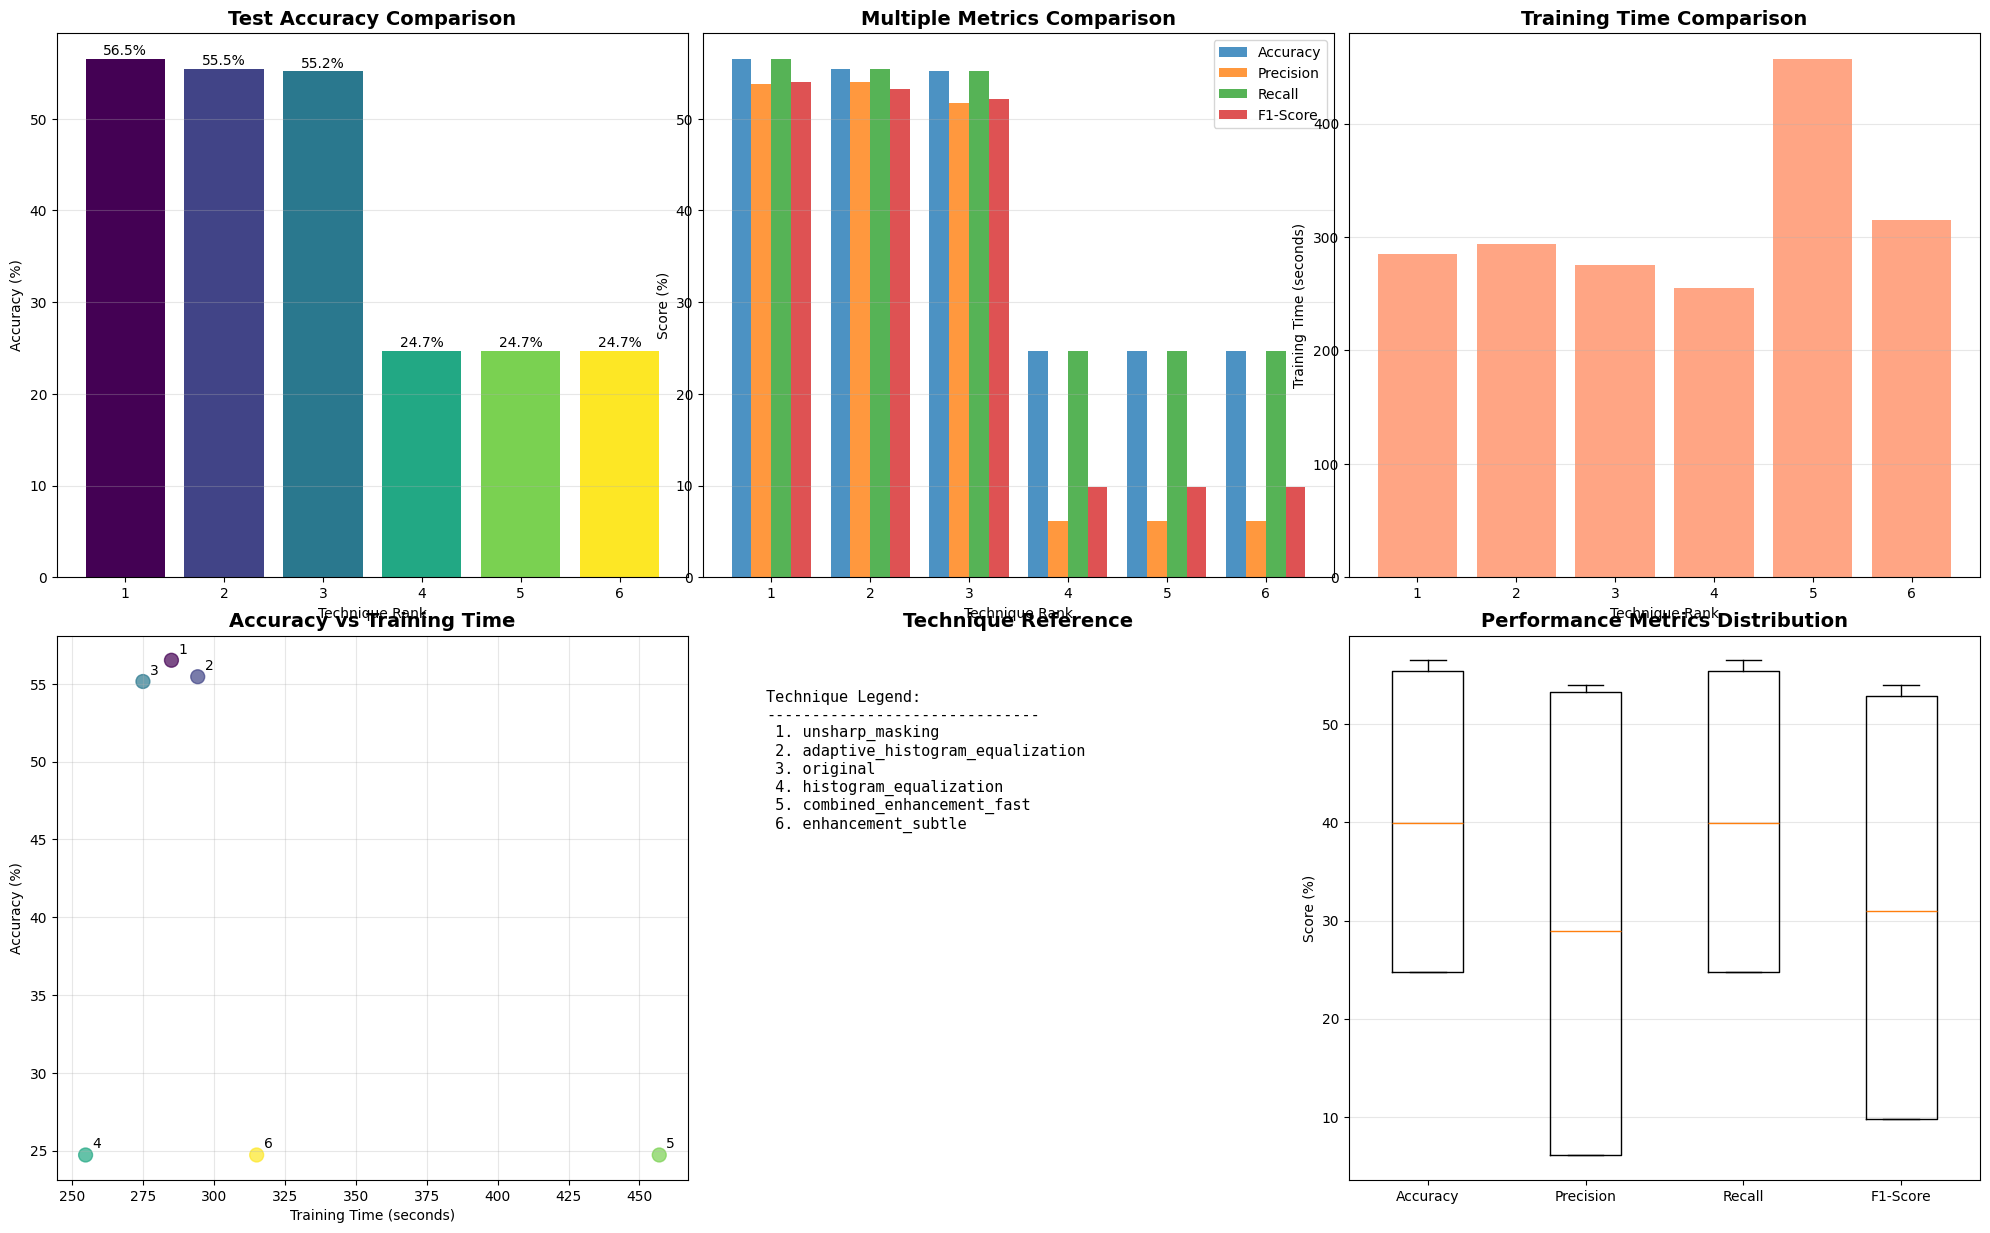

In [89]:
DATASET_PATH = "fer2013"

print(f"GPU: {torch.cuda.get_device_name() if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Define techniques to test (you can modify this list)
techniques_to_test = [
    'original',
    'histogram_equalization',
    'adaptive_histogram_equalization',
    'combined_enhancement_fast',
    'enhancement_subtle',
    'unsharp_masking',
]

print(f"\nTechniques to test: {len(techniques_to_test)}")
for i, tech in enumerate(techniques_to_test, 1):
    print(f"{i:2d}. {tech}")

try:
    # Run comparison
    results_df = compare_techniques(
        DATASET_PATH,
        techniques_to_test,
        num_epochs=20  # Reduced epochs for faster comparison
    )
except Exception as e:
    print(f"Error during execution: {e}")
    import traceback
    traceback.print_exc()


## Optimal model training

As we can see from the above output, "unsharp masking" technique worked well. So, we train a new model for 50 epochs

In [96]:
def train_with_unsharp_masking(dataset_path, num_epochs=100, batch_size=None):
    technique_name = "unsharp_masking"

    print(f"\n{'='*60}")
    print(f"TRAINING WITH TECHNIQUE: {technique_name.upper()}")
    print(f"{'='*60}")

    # Create data loaders
    train_loader, test_loader, num_classes = create_optimized_dataloaders(
        dataset_path, batch_size, technique_name
    )

    # Model
    model = HighSpeedEmotionCNN(num_classes=num_classes).to(device)

    # Mixed precision scaler
    scaler = GradScaler()

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4,
                           betas=(0.9, 0.999), eps=1e-8)

    # Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Loss function
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Track metrics
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    # Track best accuracy
    best_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")
    start_time = time.time()

    for epoch in range(num_epochs):
        # -----------------
        # TRAINING PHASE
        # -----------------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

            optimizer.zero_grad()

            with autocast():
                output = model(data)
                loss = criterion(output, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # -----------------
        # TESTING PHASE
        # -----------------
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)

                with autocast():
                    output = model(data)
                    loss = criterion(output, target)

                running_test_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_loss = running_test_loss / len(test_loader)
        test_acc = 100. * correct_test / total_test
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        # Scheduler update
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} "
              f"- Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"- Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        # -----------------
        # SAVE BEST MODEL
        # -----------------
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), f"best_model_{technique_name}.pth")
            print(f"✅ Saved new best model at epoch {epoch+1} with Test Acc: {best_acc:.2f}%")

    # -----------------
    # SAVE FINAL MODEL
    # -----------------
    torch.save(model.state_dict(), f"final_model_{technique_name}.pth")
    print("💾 Final model saved.")

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.1f}s")

    return train_losses, train_accs, test_losses, test_accs


In [97]:
# Train
train_losses, train_accs, test_losses, test_accs = train_with_unsharp_masking("fer2013")


TRAINING WITH TECHNIQUE: UNSHARP_MASKING
Loading dataset paths for technique: unsharp_masking
Loaded 28709 images
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading dataset paths for technique: unsharp_masking
Loaded 7178 images
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Pre-caching images for faster loading...
Cached 0/7178 images
Cached 1000/7178 images
Cached 2000/7178 images
Cached 3000/7178 images
Cached 4000/7178 images
Cached 5000/7178 images
Cached 6000/7178 images
Cached 7000/7178 images
Finding optimal batch size...
Batch size 32: OK
Batch size 64: OK
Batch size 128: OK
Batch size 256: OK
Batch size 512: OK
Batch size 1024: OK
Batch size 2048: OK
Optimal batch size: 1536
Starting training for 100 epochs...
Epoch 1/100 - Train Loss: 1.9683, Train Acc: 22.02% - Test Loss: 1.9745, Test Acc: 17.19%
✅ Saved new best model at epoch 1 with Test Acc: 17.19%
Epoch 2/100 - Train Loss: 1.8620, Train Acc: 24.47% - Tes

## Model evaluation

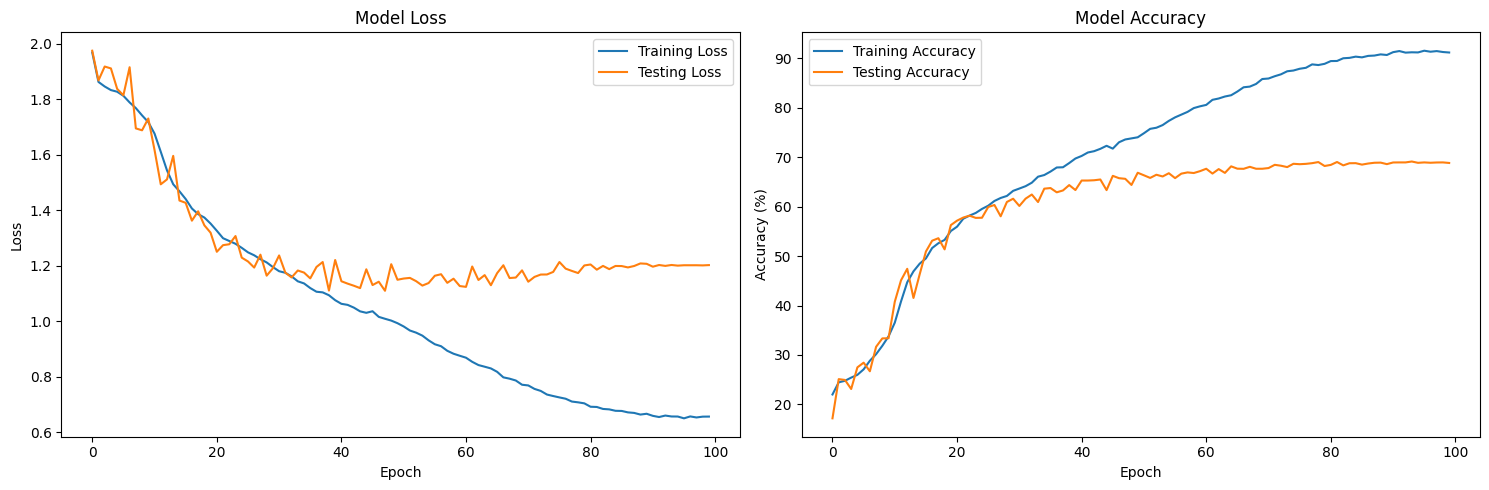

In [98]:
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Testing Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(test_accs, label='Testing Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, train_accs, test_losses, test_accs)

Loading dataset paths for technique: unsharp_masking
Loaded 28709 images
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Loading dataset paths for technique: unsharp_masking
Loaded 7178 images
Emotions: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Pre-caching images for faster loading...
Cached 0/7178 images
Cached 1000/7178 images
Cached 2000/7178 images
Cached 3000/7178 images
Cached 4000/7178 images
Cached 5000/7178 images
Cached 6000/7178 images
Cached 7000/7178 images


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795bce9a1bc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x795bce9a1bc0> 
Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers() 
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^    ^if w.is_alive():^
^ ^^  ^^ ^ ^ 
 ^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^  ^ ^ ^ ^ 
  File "/usr/li

Model Evaluation Results:
Accuracy: 0.6911
Precision: 0.6898
Recall: 0.6911
F1-Score: 0.6902

Detailed Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.63      0.62       958
     disgust       0.73      0.66      0.69       111
        fear       0.57      0.54      0.55      1024
       happy       0.86      0.89      0.87      1774
     neutral       0.64      0.62      0.63      1233
         sad       0.57      0.59      0.58      1247
    surprise       0.82      0.81      0.81       831

    accuracy                           0.69      7178
   macro avg       0.69      0.67      0.68      7178
weighted avg       0.69      0.69      0.69      7178



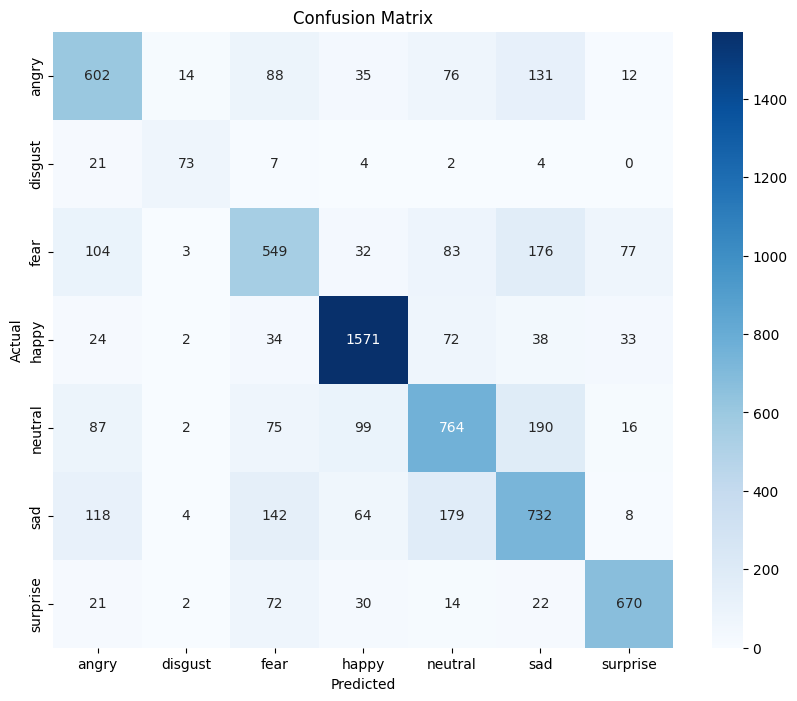

In [101]:
def evaluate_model(model, test_loader, emotion_labels):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print("Model Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(all_targets, all_predictions, target_names=emotion_labels))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, precision, recall, f1

# Load best model
model = HighSpeedEmotionCNN(num_classes=7).to(device)
# Create data loaders
train_loader, test_loader, num_classes = create_optimized_dataloaders(
  dataset_path="fer2013", batch_size=1536, technique_name="unsharp_masking"
)
model.load_state_dict(torch.load('best_model_unsharp_masking.pth'))
emotion_labels = list(train_dataset.emotion_to_idx.keys())
accuracy, precision, recall, f1 = evaluate_model(model, test_loader, emotion_labels)

## Custom prediction

In [107]:
def predict_emotion(image, model, emotion_labels, transform):

    model.eval()

    # Preprocess image
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.resize(image, (48, 48))
    image = Image.fromarray(image)
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)

        predicted_emotion = emotion_labels[predicted.item()]
        confidence = probabilities[0][predicted].item()

        return predicted_emotion, confidence, probabilities[0].cpu().numpy()

In [115]:
# Test prediction on a sample image
sample_img = cv2.imread("./fer2013/test/angry/PrivateTest_10131363.jpg", cv2.IMREAD_GRAYSCALE)
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

Sample prediction: angry with confidence 0.898


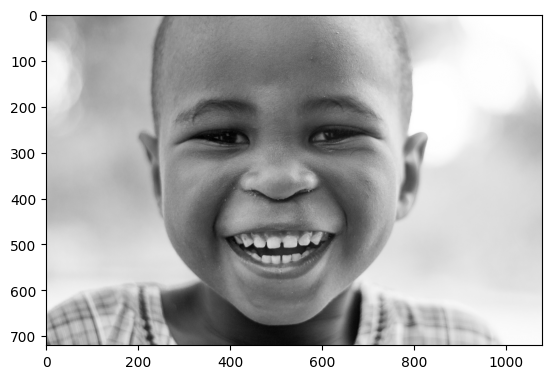

Sample prediction: happy with confidence 0.894


In [124]:
# Test prediction on a external image
sample_img = cv2.imread("./external/h1.jpg", cv2.IMREAD_GRAYSCALE)

# show image
plt.imshow(sample_img, cmap='gray')
plt.show()
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

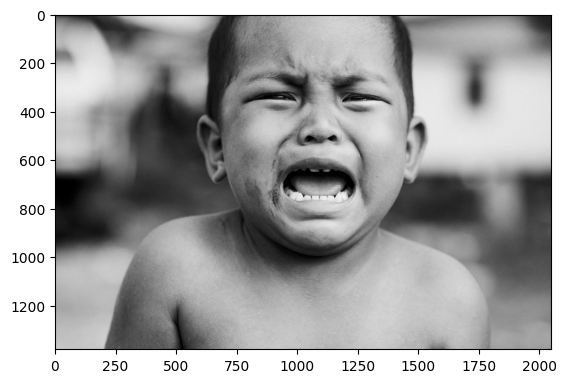

Sample prediction: sad with confidence 0.886


In [125]:
# Test prediction on a external image
sample_img = cv2.imread("./external/sad1.jpg", cv2.IMREAD_GRAYSCALE)
# show image
plt.imshow(sample_img, cmap='gray')
plt.show()
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

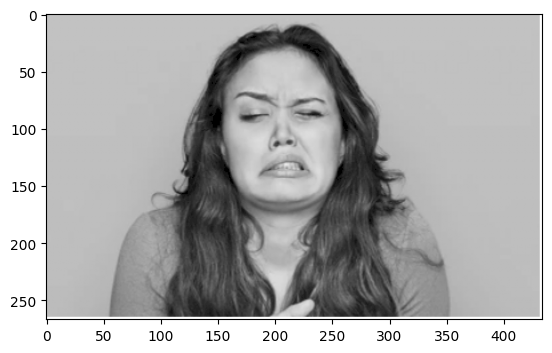

Sample prediction: surprise with confidence 0.877


In [128]:
# Test prediction on a external image
sample_img = cv2.imread("./external/disgust.png", cv2.IMREAD_GRAYSCALE)
# show image
plt.imshow(sample_img, cmap='gray')
plt.show()
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

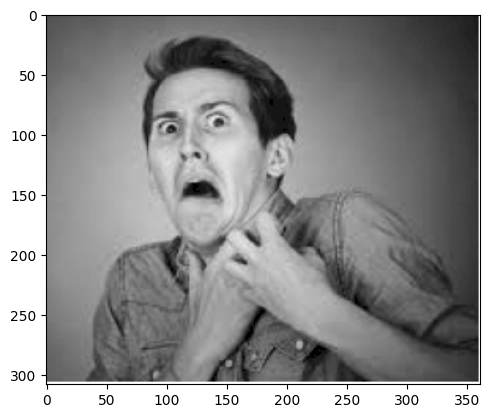

Sample prediction: fear with confidence 0.474


In [130]:
# Test prediction on a external image
sample_img = cv2.imread("./external/fear.png", cv2.IMREAD_GRAYSCALE)
# show image
plt.imshow(sample_img, cmap='gray')
plt.show()
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

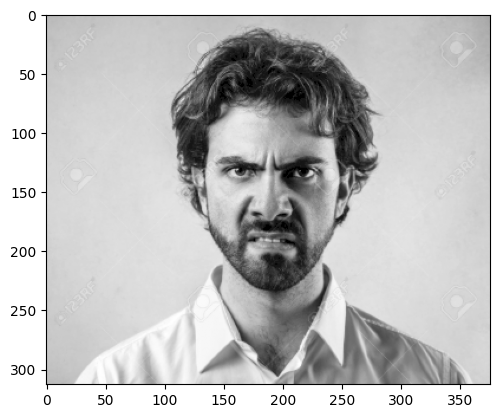

Sample prediction: angry with confidence 0.412


In [131]:
# Test prediction on a external image
sample_img = cv2.imread("./external/angry.png", cv2.IMREAD_GRAYSCALE)
# show image
plt.imshow(sample_img, cmap='gray')
plt.show()
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

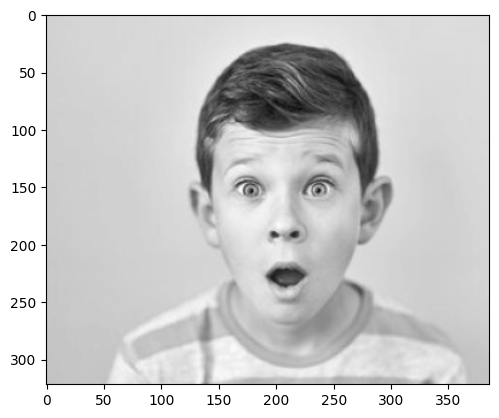

Sample prediction: surprise with confidence 0.861


In [132]:
# Test prediction on a external image
sample_img = cv2.imread("./external/surprise.png", cv2.IMREAD_GRAYSCALE)
# show image
plt.imshow(sample_img, cmap='gray')
plt.show()
emotion, confidence, probs = predict_emotion(sample_img, model, emotion_labels, test_transform)
print(f"Sample prediction: {emotion} with confidence {confidence:.3f}")

## Real-time prediction

In [116]:
def webcam_emotion_detection():

    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Detect faces
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        detector = dlib.get_frontal_face_detector()
        faces = detector(gray)

        for face in faces:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()

            # Extract face
            face_img = gray[y:y+h, x:x+w]

            # Predict emotion
            emotion, confidence, probabilities = predict_emotion(
                face_img, model, emotion_labels, test_transform
            )

            # Draw rectangle and label
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            label = f'{emotion}: {confidence:.2f}'
            cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2.imshow('Emotion Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()



In [117]:
webcam_emotion_detection()